In [1]:
import napari
import numpy as np
import logging

from blimp.data import load_example_data
from blimp.log import configure_logging
from blimp.constants import blimp_config
from aicsimageio import AICSImage
from pathlib import Path

configure_logging(verbosity=2)
# ensure that example data is downloaded
example_data_path = load_example_data()
# read correct blimp_config -- created with 0_setup.ipynb
blimp_config.config_fname = "blimp.ini"
print(blimp_config)


07-Feb-23 16:10:37 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


Reading config from /Users/scottberry/.config/blimp/blimp.ini
unpacked_dir = /Users/scottberry/source/blimp/notebooks/_data/raw
archive_path = /Users/scottberry/source/blimp/notebooks/_data/archive/_data.zip
BLIMPConfig (fname: /Users/scottberry/.config/blimp/blimp.ini)
EXPERIMENT_DIR: /Users/scottberry/source/blimp
BASE_DATA_DIR: /Users/scottberry/source/blimp
data_config/exampledata: /Users/scottberry/source/blimp/notebooks/ExampleData_constants.py



In [2]:
from blimp.image import BLImage 
cyc01 = BLImage(example_data_path / '_data' / 'operetta_cls_multiplex' / 'cycle_01' / 'r05c03f15-fk1fl1-mip.ome.tiff')

The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


In [4]:
cyc01

<BLImage [Reader: OmeTiffReader, dtype: uint16, Image-is-in-Memory: False]>

In [ ]:
cyc01.x


In [ ]:
bl = cyc01.shift_yx(1,1)
bl.get_image_data('YX',Z=0,T=0,C=0)

In [ ]:
cyc01.shift_yx

In [ ]:
cyc01.get_image_data('YX',Z=0,T=0,C=0)

In [ ]:
from blimp.preprocessing.registration import TransformationParameters
cyc01.transformation_parameters = TransformationParameters(transformation_mode='rigid')
print(cyc01.transformation_parameters)

In [78]:
def vollath_f4(arr : np.ndarray):
    """Vollath's F4 function.
    
    Described in https://doi.org/10.1002/jemt.24035

    Code adapted from https://github.com/aquimb/Autofocus-URJC/blob/d3b83382a82315e27e248d09519e3da4dbac40f6/Code/algorithms.py#L200
    """
    sum1 = 0
    sum2 = 0
    rows = arr.shape[0]
    cols = arr.shape[1]
    for i in range(rows - 1):
        sum1 = sum1 + (arr[i] * arr[i + 1])

    for i in range(rows - 2):
        sum2 = sum2 + (arr[i] * arr[i + 2])

    sum3 = (sum1 - sum2)
    res = 0
    for i in range(cols):
        res = res + sum3[i]

    return res

blimp_config.config_fname = "blimp.ini"
# load the exampledata configuration
example_data_config = blimp_config.get_data_config('exampledata')
FISH = AICSImage(Path(example_data_config.DATA_DIR) / 'nstorm_multichannel_fish' /  'well3_channelag_647_fish,ag_568_fish_quad,ag_488nhs,ag_dapi_seq0002_0003.ome.tiff')


The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


In [201]:
from typing import Optional
def estimate_focus_plane(
    image : AICSImage,
    C : Optional[int],
    sliding_window_averaging: Optional[int] = None,
    crop : float = 1.0
) -> int:

    if not isinstance(crop,float):
        raise TypeError("``crop`` must be of type float")

    if C is None:
        #logger.warning("Using default channel (C = 0) to calculate focus_plane")
        C = 0

    arrays = [image.get_image_data("YX",T=0,C=C,Z=i) for i in range(image.dims.Z)]
    if crop < 1.0:
        ymin = np.floor((1.0-crop) * arrays[0].shape[0]).astype(int)
        ymax = np.ceil(crop * arrays[0].shape[0]).astype(int)
        xmin = np.floor((1.0-crop) * arrays[0].shape[1]).astype(int)
        xmax = np.ceil(crop * arrays[0].shape[1]).astype(int)
        arrays = [a[ymin:ymax, xmin:xmax] for a in arrays]
    elif crop!=1.0:
        raise ValueError("``crop`` must be < 1")

    f4 = [vollath_f4(arr) for arr in arrays]
    intensity = [np.mean(arr) for arr in arrays]

    if sliding_window_averaging is not None and sliding_window_averaging > 0:
        # average
        f4_avg = list(np.convolve(f4, np.ones(sliding_window_averaging)/sliding_window_averaging, mode='valid'))
        # pad with zeros
        if sliding_window_averaging % 2 == 0:
            pad_left = list(np.zeros([np.floor(float(sliding_window_averaging-1)/2.).astype(int)], dtype=type(f4[0])))
        else:
            pad_left = list(np.zeros([np.floor(float(sliding_window_averaging)/2.).astype(int)], dtype=type(f4[0])))
        pad_right = list(np.zeros([np.floor(float(sliding_window_averaging)/2.).astype(int)], dtype=type(f4[0])))
        f4 = pad_left + f4_avg + pad_right
        # find max
        max_pos = np.argmax(f4_avg) + len(pad_left)
    else:
        max_pos = np.argmax(f4)

    return  max_pos

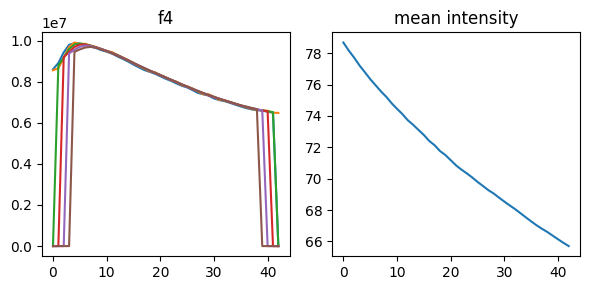

In [208]:
from matplotlib import pyplot as plt

focus_plane, f4_raw, intensity = estimate_focus_plane(FISH,C=2,crop=0.75,sliding_window_averaging=2)
f4_window = [estimate_focus_plane(FISH,C=2,sliding_window_averaging=i,crop=0.75)[1] for i in range(1,10,2)]
focus_plane_window = [estimate_focus_plane(FISH,C=2,sliding_window_averaging=i,crop=0.75)[0] for i in range(1,10,2)]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].plot(range(len(f4_raw)),f4_raw)
[axes[0].plot(range(len(f4_raw)),fw) for fw in f4_window]
axes[0].set_title("f4")
axes[1].plot(range(len(intensity)),intensity)
axes[1].set_title("mean intensity")
fig.tight_layout()

In [204]:
focus_plane_window

[5, 6, 6, 7]